<a href="https://colab.research.google.com/github/MarcosVeniciu/Xception-CNN---Plant-Pathology-2020/blob/main/Xception_pre_treinada_Plant_Pathology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Criação do DataSet [5]

## Configuração do Keggle e Download do DataSet [1]

In [ ]:
# Intalação do keggle

! pip install -q kaggle

In [ ]:
# Lê o arquivo Kaggle.json

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"marcosveniciu","key":"27c3f3373ca739f6cffb0e17f17fdc27"}'}

In [ ]:
# Cria uma pasta chamada Keggle e copia o arquivo Json para ela.
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

# Altera as permisções para o arquivo keggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Verifica uma lista de dataset do keggle. Se a lista for exibida, esntão ta tudo certo. (opcional)
! kaggle datasets list

In [ ]:
# Download do DataSet que eu quero: https://www.kaggle.com/competitions/plant-pathology-2020-fgvc7/data
# É preciso aceitar as regras na aba de Rules para poder fazer o dosnloas do dataset

! kaggle competitions download -c plant-pathology-2020-fgvc7

 97% 755M/779M [00:04<00:00, 293MB/s]
100% 779M/779M [00:04<00:00, 176MB/s]


In [ ]:
# Descompacta o arquivo plant-pathology-2020-fgvc7

! unzip plant-pathology-2020-fgvc7.zip

As imagens estão todas na mesma pasta. \
As imagens de testes vão de Test_0 ate Test_1820. \
As imagens de treino vão de Train_0 ate Train_1820.

## Preparação do DataSet

In [ ]:
# healthy = 1 planta saldavel, healthy = 0 alguma doença: multiple_diseases, rust ou scab
import pandas as pd

dataset = pd.read_csv("/content/train.csv")
dataset

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0
...,...,...,...,...,...
1816,Train_1816,0,0,0,1
1817,Train_1817,1,0,0,0
1818,Train_1818,1,0,0,0
1819,Train_1819,0,0,1,0


In [ ]:
# Cria os diretórios para as imagens

!mkdir Imagens_plantas
!mkdir Imagens_plantas/saudaveis
!mkdir Imagens_plantas/doentes

!mkdir Plantas_teste
!mkdir Plantas_teste/saudaveis
!mkdir Plantas_teste/doentes

In [ ]:
# move as imagens de plantas saldaveis e doentes para a sua respectiva pasta em Imagens_plantas
import os
import shutil

for i in range (1821): #0 ate 1820
  caminho_origem =  "/content/images/Train_" + str(i) + ".jpg"

  if(dataset['healthy'][i] == 1):
    shutil.move(caminho_origem, "/content/Imagens_plantas/saudaveis")
  else:
    shutil.move(caminho_origem, "/content/Imagens_plantas/doentes")

In [ ]:
# Contar o numero de imagens nas pastas
# Treino
!echo DataSet Folhas Saldaveis
!ls /content/Imagens_plantas/saudaveis/*.jpg | wc | awk '{print $1}' 
!echo DataSet Folhas Doentes
!ls /content/Imagens_plantas/doentes/*.jpg | wc | awk '{print $1}'


# Testes
!echo Testes Folhas
!ls /content/images/*.jpg | wc | awk '{print $1}'

DataSet Folhas Saldaveis
516
DataSet Folhas Doentes
1305
Testes Folhas
1821


# Xception network [2]


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Pré-processamento das imagens de treino e validação

In [ ]:
image_size = (180, 180)
batch_size = 32

In [ ]:
diretorio_imagens = "/content/Imagens_plantas"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    diretorio_imagens,
    validation_split=0.2, # proporção das imagens que estão na pasta e vao ser usados para a validação. Os 80% restantes seram para o treino
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    diretorio_imagens,
    validation_split=0.2, # proporção das imagens que estão na pasta e vao ser usados para a validação. Os 80% restantes seram para o treino
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1033 files belonging to 4 classes.
Using 827 files for training.
Found 1033 files belonging to 4 classes.
Using 206 files for validation.


In [ ]:
# Verifica o nome da classe (diretorio das imagens) e o indice dela
print(train_ds.class_names)
print(val_ds.class_names)

['multiple_diseases', 'rust', 'saudaveis', 'scab']
['multiple_diseases', 'rust', 'saudaveis', 'scab']


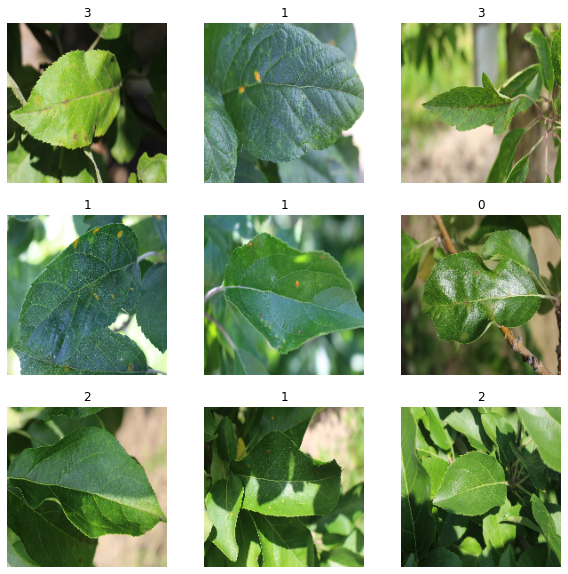

In [ ]:
# Visualizar algumas das imagens. Onde o numero acima da imagen indica o indice da classe. 1 para saudaveis e 0 para doentes.

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
# Aplicando algumas transformações nas imagens, para aumentar o dataset

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

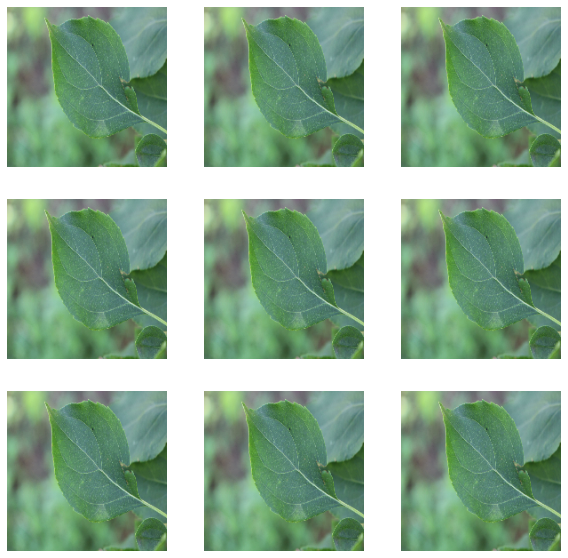

In [ ]:
# Exibir alguns exemplos de transformações

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
# Configurando o dataset
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

## Construindo o Modelo

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


In [ ]:
model.summary()

## Treinando o Modelo

Posso caregar os pesos salvo e continuar treinando a partir deses pesos ou ir direto para a previsão.

In [ ]:
# Fazendo o upload do arquivo com os pesos pre-treinado
from google.colab import files
files.upload()

Saving Xception_save_at_200.h5 to Xception_save_at_200.h5


In [ ]:
# Carregando os pesos no modelo
Local = "/content/Xception_save_at_200.h5"
model.load_weights(Local)

Continuar com o treinamento ou começar um novo treinamento.

In [ ]:
# Loss = binary_crossentropy para ate duas classes e categorical_crossentropy para mais
epochs = 200


callbacks = [
    keras.callbacks.ModelCheckpoint("{epoch}_epocs_Xception.h5"), # Salva os pessos
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [ ]:
historico = model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/200


ValueError: ignored

In [ ]:
# Cruva de aprendizado [4]
from matplotlib import pyplot

plt.subplots(figsize=(15, 5)) 
# Grafico 1
pyplot.subplot(1,2,1)
pyplot.title('Curva de Aprendizado: Train')
pyplot.xlabel('Epoch')
pyplot.ylabel('Cross Entropy')
pyplot.grid()
pyplot.plot(historico.history['loss'], color = 'blue')

# Grafico 2
pyplot.subplot(1,2,2)
pyplot.title('Curva de Aprendizado: Val')
pyplot.xlabel('Epoch')
pyplot.ylabel('Cross Entropy')
pyplot.grid()
pyplot.plot(historico.history['val_loss'], color = 'red')

pyplot.show()

In [ ]:
# Remover pesos desnecessários
import os

for i in range(epochs-1):
  os.remove('/content/' + str(i+1) + '_epocs_Xception.h5')

In [ ]:
#Salvando os pesos do Treinamento em outra pasta
#!cp save_at_5.h5 /content/Dog_Cat/dogs-vs-cats.h5

## Predição

 Classe das imagens: 1 para saudáveis e 0 para doentes.

### Imagen Unica

This image is 100.00 percent Doente and 0.00 percent Saudável.


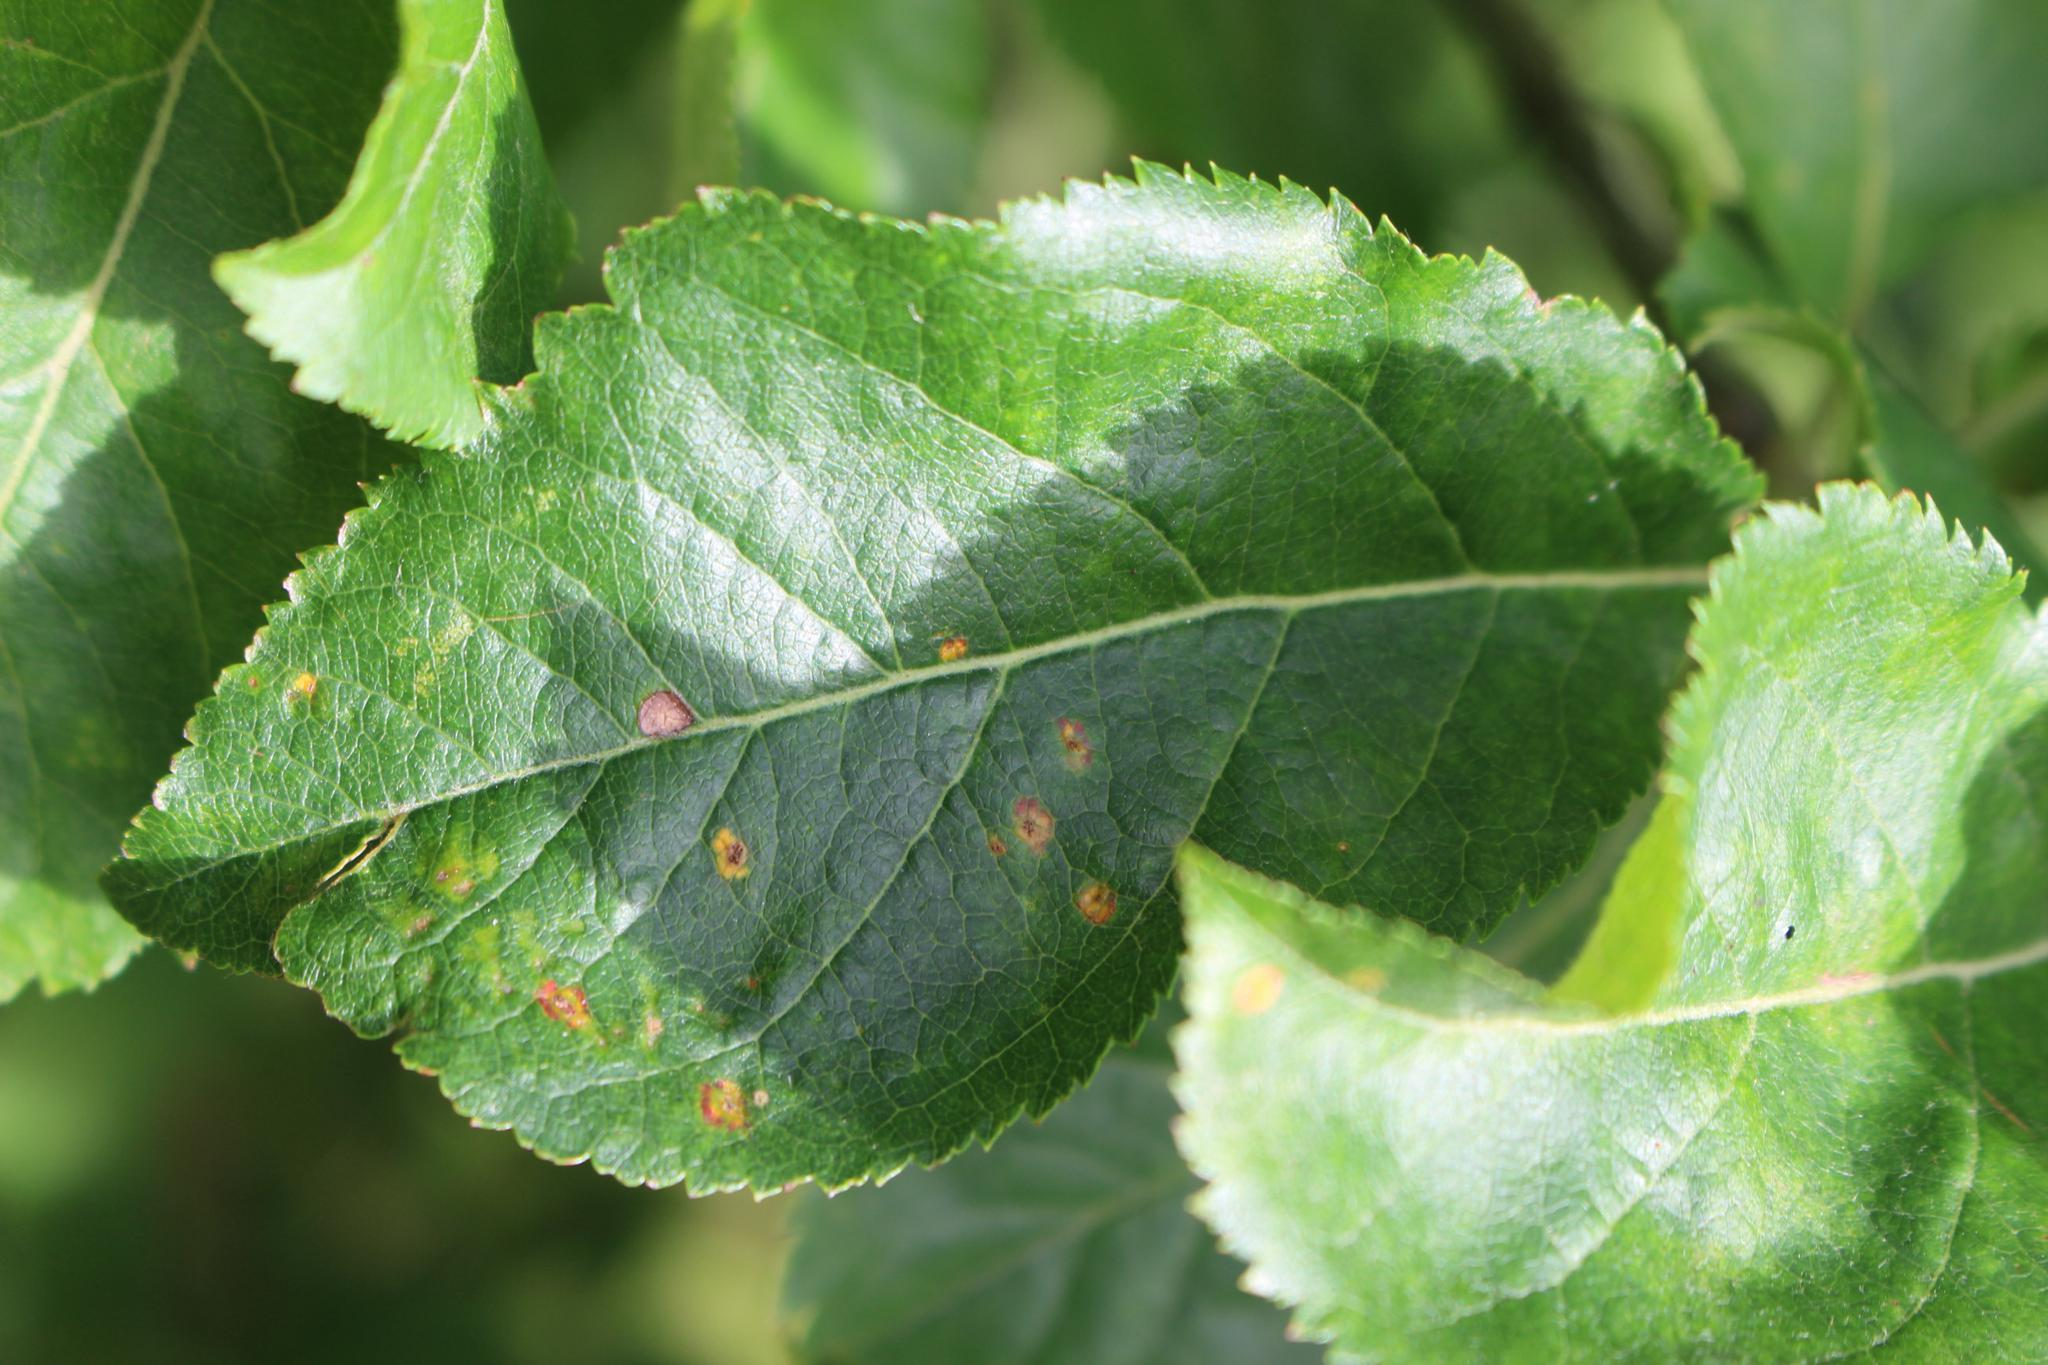

In [ ]:
filename = "/content/images/Test_1.jpg"


img = keras.preprocessing.image.load_img(
    filename, target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent Doente and %.2f percent Saudável."
    % (100 * (1 - score), 100 * score)
)
from IPython.display import Image, display
display(Image(filename))

### Multiplas imagens

In [ ]:
numero_imagens = 100
confianca = 99 # se o modelo tiver 80% ou mais de certeza que a imagem é saudável, então ela sera classificada como saudável

saudavel = 0
doente = 0

for i in range(numero_imagens):
  filename = '/content/Plantas_teste/saudaveis/A (' + str(i+1) + ').jpg' 
  

  img = keras.preprocessing.image.load_img(
     filename, target_size=image_size
  )
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis

  predictions = model.predict(img_array)
  score = predictions[0]

  
  if (100*score) >= confianca: # ser Saudável
     saudavel = saudavel +1
  else:
    if (100 * (1 - score)) >= confianca: # ser Doente
      doente = doente +1

nao_sabe = numero_imagens - (saudavel + doente)
porcentagem_doentes = (doente / numero_imagens) * 100
porcentagem_saudaveis = (saudavel / numero_imagens) * 100
porcentagem_nao_sabe = (nao_sabe / numero_imagens) * 100
      
print("Das "+ str(numero_imagens) + " Analisada: " + str(saudavel) +" ("+ str(porcentagem_saudaveis) +" %)"+ " são saudáveis e "
     +  str(doente) +" ("+ str(porcentagem_doentes) +" %)" + " são Doentes." + " Com "+ str(confianca) +"% ou mais de confiança.")
print("E "+ str( nao_sabe) +" ("+ str(porcentagem_nao_sabe) +" %)" + " tem menos de " + str(confianca) + "% de certeza se é saudáveis ou Doente.")

Das 100 Analisada: 92 (92.0 %) são saudáveis e 4 (4.0 %) são Doentes. Com 99% ou mais de confiança.
E 4 (4.0 %) tem menos de 99% de certeza se é saudáveis ou Doente.


### Predição para CSV

In [ ]:
# Cria um data frame para as previsões do modelo
import pandas as pd

# Criando o DataFrame vazio
df_xception = pd.DataFrame([], columns=['Amostra', 'Precisao', 'Saudaveis', 'Doentes', 'Incertos'])

In [ ]:
# Realizar as medições
numero_imagens = 100


Amostra = 1  # 1 para saudaveis e 0 para doentes.
while (Amostra >= 0):
  
  for confianca in range(50, 101): # Medir a confianca entre 50% e 100%
    print(nome +": Executando: " + str(confianca) + "% confiança.") 
    
    saudavel = 0
    doente = 0


    # Classificação
    for i in range(numero_imagens):

      # Especifica se é a amostra saudavel ou doente
      if (Amostra == 1):
        filename = '/content/Plantas_teste/saudaveis/A (' + str(i+1) + ').jpg'
        nome = "saudavel"  
      else:
        filename = '/content/Plantas_teste/doentes/A (' + str(i+1) + ').jpg'
        nome = "doente" 


      img = keras.preprocessing.image.load_img(
      filename, target_size=image_size
      )
      img_array = keras.preprocessing.image.img_to_array(img)
      img_array = tf.expand_dims(img_array, 0)  # Create batch axis

      predictions = model.predict(img_array)
      score = predictions[0]

    
      if (100*score) >= confianca: # ser Saudável
        saudavel = saudavel +1
      else:
        if (100 * (1 - score)) >= confianca: # ser Doente
          doente = doente +1

    nao_sabe = numero_imagens - (saudavel + doente)
    porcentagem_doentes = (doente / numero_imagens) * 100
    porcentagem_saudaveis = (saudavel / numero_imagens) * 100
    porcentagem_nao_sabe = (nao_sabe / numero_imagens) * 100

    # Adiciona o resultado na Tabela
    df_xception_pre_treinado = df_xception_pre_treinado.append({'Amostra' : nome , 'Precisao' : confianca, 'Saudaveis' : porcentagem_saudaveis,
                                                             'Doentes' : porcentagem_doentes, 'Incertos' : porcentagem_nao_sabe} , ignore_index=True)
  Amostra = Amostra -1

In [ ]:
#Criando o CSV
Nome_arquivo = "450_epocs_dataset_balanceado_Xception.csv"
df_xception.to_csv(Nome_arquivo, index = False)

# Xception network - Pré-Treinada [6]

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Pré-processamento das imagens de treino e validação

In [ ]:
diretorio_imagens = "/content/Imagens_plantas"

image_size = (150, 150)
batch_size = 32


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    diretorio_imagens,
    validation_split=0.2, # proporção das imagens que estão na pasta e vao ser usados para a validação. Os 80% restantes seram para o treino
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    diretorio_imagens,
    validation_split=0.2, # proporção das imagens que estão na pasta e vao ser usados para a validação. Os 80% restantes seram para o treino
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1033 files belonging to 4 classes.
Using 827 files for training.
Found 1033 files belonging to 4 classes.
Using 206 files for validation.


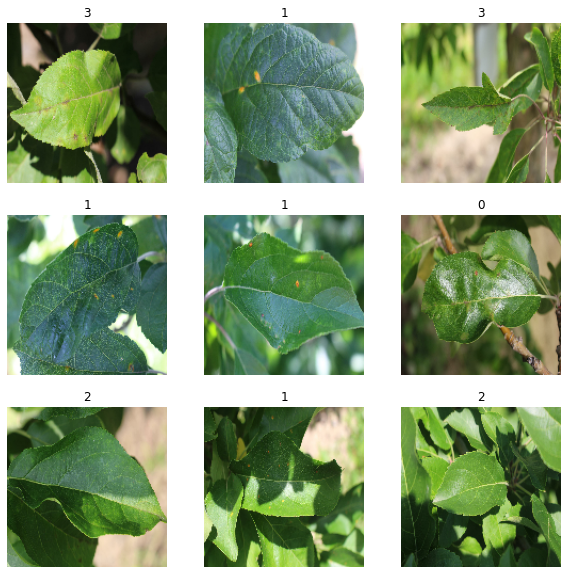

In [ ]:
# Visualizar algumas das imagens. Onde o numero acima da imagen indica o indice da classe. 1 para saudaveis e 0 para doentes.

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
# Aplicando algumas transformações nas imagens, para aumentar o dataset

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

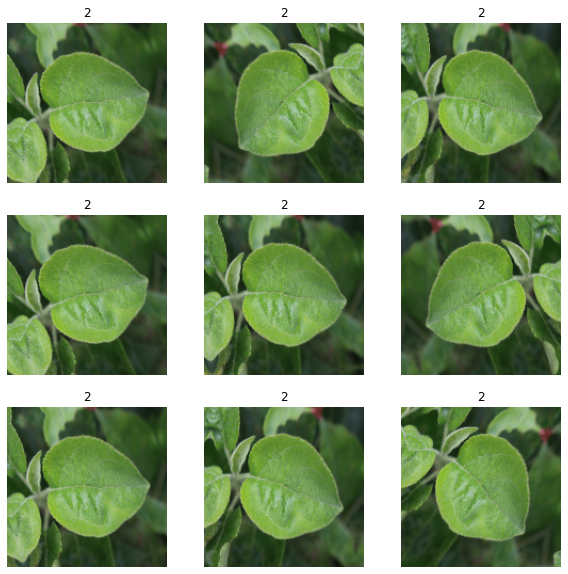

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

## Construindo Modelo

model foi renomeado para model_2 para evitar problemas com o nome do Xeption que também se chama model. 

In [ ]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
#outputs = keras.layers.Dense(1)(x)
# Para duas classes
outputs = keras.layers.Dense(1, activation = "sigmoid")(x)

# Para mais de duas classes 
#outputs = keras.layers.Dense(4)(x)

model_2 = keras.Model(inputs, outputs)

In [ ]:
model_2.summary()

## Treinando a Camada Superior

In [ ]:
# binary_crossentropy para duas classes e categorical_crossentropy para mais de duas categorias
model_2.compile(
    optimizer=keras.optimizers.Adam(),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)


epochs = 20
historico = model_2.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/20
26/26 [==============================] - 13s 311ms/step - loss: -3.3941 - accuracy: 0.2104 - val_loss: -7.8353 - val_accuracy: 0.1893
Epoch 2/20
26/26 [==============================] - 10s 331ms/step - loss: -9.5887 - accuracy: 0.2104 - val_loss: -15.1156 - val_accuracy: 0.1893
Epoch 3/20


KeyboardInterrupt: ignored

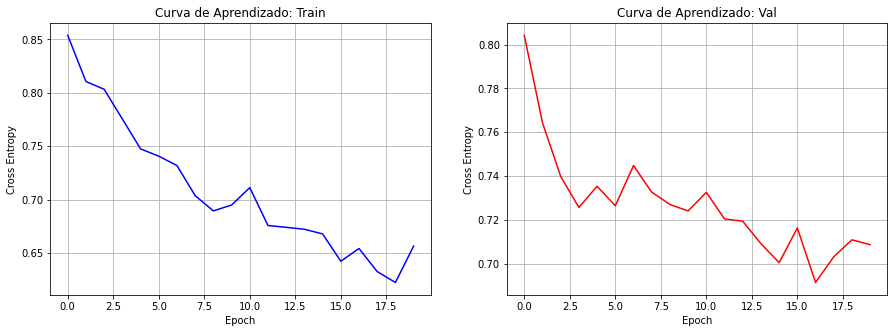

In [ ]:
# Cruva de aprendizado [4]
from matplotlib import pyplot

plt.subplots(figsize=(15, 5)) 
# Grafico 1
pyplot.subplot(1,2,1)
pyplot.title('Curva de Aprendizado: Train')
pyplot.xlabel('Epoch')
pyplot.ylabel('Cross Entropy')
pyplot.grid()
pyplot.plot(historico.history['loss'], color = 'blue')

# Grafico 2
pyplot.subplot(1,2,2)
pyplot.title('Curva de Aprendizado: Val')
pyplot.xlabel('Epoch')
pyplot.ylabel('Cross Entropy')
pyplot.grid()
pyplot.plot(historico.history['val_loss'], color = 'red')

pyplot.show()

## Ajuste fino em todo o modelo

Finalmente, vamos descongelar o modelo base e treinar todo o modelo de ponta a ponta com uma baixa taxa de aprendizado.

É importante ressaltar que, embora o modelo base se torne treinável, ele ainda está sendo executado no modo de inferência, pois passamos training=False ao chamá-lo quando construímos o modelo. Isso significa que as camadas de normalização de lote internas não atualizarão suas estatísticas de lote. Se o fizessem, causariam estragos nas representações aprendidas pelo modelo até agora.

In [ ]:
# binary_crossentropy para duas classes e categorical_crossentropy para mais de duas categorias
base_model.trainable = True
model_2.summary()

model_2.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss= "binary_crossentropy",
    metrics=["accuracy"],
)


epochs = 10
historico = model_2.fit(train_ds, epochs=epochs, validation_data=val_ds)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                           

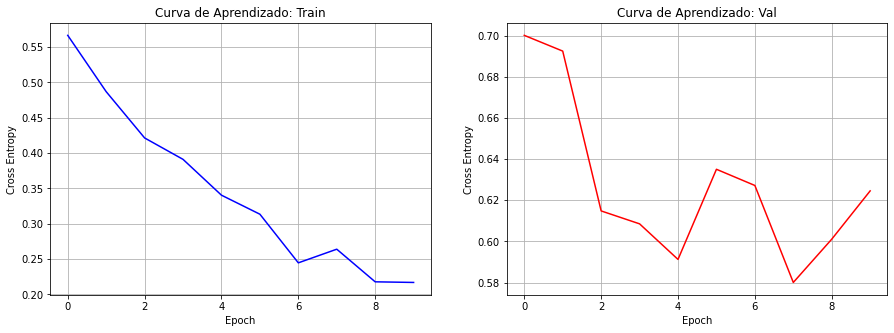

In [ ]:
# Cruva de aprendizado [4]
from matplotlib import pyplot

plt.subplots(figsize=(15, 5)) 
# Grafico 1
pyplot.subplot(1,2,1)
pyplot.title('Curva de Aprendizado: Train')
pyplot.xlabel('Epoch')
pyplot.ylabel('Cross Entropy')
pyplot.grid()
pyplot.plot(historico.history['loss'], color = 'blue')

# Grafico 2
pyplot.subplot(1,2,2)
pyplot.title('Curva de Aprendizado: Val')
pyplot.xlabel('Epoch')
pyplot.ylabel('Cross Entropy')
pyplot.grid()
pyplot.plot(historico.history['val_loss'], color = 'red')

pyplot.show()

## Predição

### Imagen Unica

In [ ]:
from keras.applications.xception import decode_predictions
filename = "/content/Plantas_teste/saudaveis/A (3).jpg"


img = keras.preprocessing.image.load_img(
    filename, target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model_2.predict(img_array)

score = predictions[0]
print(
    "This image is %.2f percent Doente and %.2f percent Saudável."
    % (100 * (1 - score), 100 * score)
)
from IPython.display import Image, display
display(Image(filename))

[[-3.152736  -4.410066   2.0134897 -4.713029 ]]


TypeError: ignored

### Multiplas imagens

In [ ]:
numero_imagens = 100
confianca = 90 # se o modelo tiver 80% ou mais de certeza que a imagem é saudável, então ela sera classificada como saudável

saudavel = 0
doente = 0

for i in range(numero_imagens):
  filename = '/content/Plantas_teste/saudaveis/A (' + str(i+1) + ').jpg' 
  #filename = "/content/images/Test_" + str(i+1) + ".jpg"

  img = keras.preprocessing.image.load_img(
     filename, target_size=image_size
  )
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis

  predictions = model_2.predict(img_array)
  score = predictions[0]

  
  if (100*score) >= confianca: # ser Saudável
     saudavel = saudavel +1
  else:
    if (100 * (1 - score)) >= confianca: # ser Doente
      doente = doente +1

nao_sabe = numero_imagens - (saudavel + doente)
porcentagem_doentes = (doente / numero_imagens) * 100
porcentagem_saudaveis = (saudavel / numero_imagens) * 100
porcentagem_nao_sabe = (nao_sabe / numero_imagens) * 100
      
print("Das "+ str(numero_imagens) + " Analisada: " + str(saudavel) +" ("+ str(porcentagem_saudaveis) +" %)"+ " são saudáveis e "
     +  str(doente) +" ("+ str(porcentagem_doentes) +" %)" + " são Doentes." + " Com "+ str(confianca) +"% ou mais de confiança.")
print("E "+ str( nao_sabe) +" ("+ str(porcentagem_nao_sabe) +" %)" + " tem menos de " + str(confianca) + "% de certeza se é saudáveis ou Doente.")

ValueError: ignored

### Predição para CSV.

In [ ]:
# Cria um data frame para as previsões do modelo
import pandas as pd

# Criando o DataFrame vazio
df_xception_pre_treinado = pd.DataFrame([], columns=['Amostra', 'Precisao', 'Saudaveis', 'Doentes', 'Incertos'])

In [ ]:
# Realizar as medições
numero_imagens = 100


Amostra = 1  # 1 para saudaveis e 0 para doentes.
while (Amostra >= 0):
  
  for confianca in range(50, 101): # Medir a confianca entre 50% e 100%
    print("Amostra: "+ str(Amostra) +": Executando: " + str(confianca) + "% confiança.") 
    
    saudavel = 0
    doente = 0


    # Classificação
    for i in range(numero_imagens):

      # Especifica se é a amostra saudavel ou doente
      if (Amostra == 1):
        filename = '/content/Plantas_teste/saudaveis/A (' + str(i+1) + ').jpg'
        nome = "saudavel"  
      else:
        filename = '/content/Plantas_teste/doentes/A (' + str(i+1) + ').jpg'
        nome = "doente" 


      img = keras.preprocessing.image.load_img(
      filename, target_size=image_size
      )
      img_array = keras.preprocessing.image.img_to_array(img)
      img_array = tf.expand_dims(img_array, 0)  # Create batch axis

      predictions = model_2.predict(img_array)
      score = predictions[0]

    
      if (100*score) >= confianca: # ser Saudável
        saudavel = saudavel +1
      else:
        if (100 * (1 - score)) >= confianca: # ser Doente
          doente = doente +1

    nao_sabe = numero_imagens - (saudavel + doente)
    porcentagem_doentes = (doente / numero_imagens) * 100
    porcentagem_saudaveis = (saudavel / numero_imagens) * 100
    porcentagem_nao_sabe = (nao_sabe / numero_imagens) * 100

    # Adiciona o resultado na Tabela
    df_xception_pre_treinado = df_xception_pre_treinado.append({'Amostra' : nome , 'Precisao' : confianca, 'Saudaveis' : porcentagem_saudaveis,
                                                             'Doentes' : porcentagem_doentes, 'Incertos' : porcentagem_nao_sabe} , ignore_index=True)
  Amostra = Amostra -1

Amostra: 1: Executando: 50% confiança.
Amostra: 1: Executando: 51% confiança.
Amostra: 1: Executando: 52% confiança.
Amostra: 1: Executando: 53% confiança.
Amostra: 1: Executando: 54% confiança.
Amostra: 1: Executando: 55% confiança.
Amostra: 1: Executando: 56% confiança.
Amostra: 1: Executando: 57% confiança.
Amostra: 1: Executando: 58% confiança.
Amostra: 1: Executando: 59% confiança.
Amostra: 1: Executando: 60% confiança.
Amostra: 1: Executando: 61% confiança.
Amostra: 1: Executando: 62% confiança.
Amostra: 1: Executando: 63% confiança.
Amostra: 1: Executando: 64% confiança.
Amostra: 1: Executando: 65% confiança.
Amostra: 1: Executando: 66% confiança.
Amostra: 1: Executando: 67% confiança.
Amostra: 1: Executando: 68% confiança.
Amostra: 1: Executando: 69% confiança.
Amostra: 1: Executando: 70% confiança.
Amostra: 1: Executando: 71% confiança.
Amostra: 1: Executando: 72% confiança.
Amostra: 1: Executando: 73% confiança.
Amostra: 1: Executando: 74% confiança.
Amostra: 1: Executando: 7

In [ ]:
#Criando o CSV
Nome_arquivo = "100_60_epocs_Xception_pre_treinada.csv"
df_xception_pre_treinado.to_csv(Nome_arquivo, index = False)

# Referências

[1] Baixar dados do Keggle. [video] https://www.youtube.com/watch?v=57N1g8k2Hwc [Site] https://www.kaggle.com/general/74235 \

[2] 10/06 - Modelo de rede para cassificar imagens, que foi usado de exemplo na aulas. \
Colab: https://colab.research.google.com/drive/1MrVHG5B0xJB83G4hz8fSfgBCn7PwHAoh?usp=sharing#scrollTo=PfojoMdo5s8H  \

[3] Explicação da rede Xception: https://maelfabien-github-io.translate.goog/deeplearning/xception/?_x_tr_sl=en&_x_tr_tl=pt&_x_tr_hl=pt-BR&_x_tr_pto=sc \

[4] Curva de aprendizado https://jobu.com.br/2021/07/15/tutorial-do-tensorflow-2/ \

[5] site do DataSet https://www.kaggle.com/competitions/plant-pathology-2020-fgvc7/overview \

[6] 23/06 - Modelo Xception pre-treinada: https://keras.io/guides/transfer_learning/#do-a-round-of-finetuning-of-the-entire-model


# Extras

In [ ]:
# Apagar diretorio com arquivos

import shutil
pasta = "/content/Imagens_plantas"
shutil.rmtree(pasta, ignore_errors=True)

In [ ]:
# Contar o numero de imagens de cada classe

saudavel = 0
multiplas = 0
rust = 0
scab = 0

for i in range(1820):
  if(dataset['healthy'][i] == 1):
    saudavel = saudavel +1
  if(dataset['multiple_diseases'][i] == 1):
    multiplas = multiplas +1
  if(dataset['rust'][i] == 1):
    rust = rust +1
  if(dataset['scab'][i] == 1):
    scab = scab +1

print("saudavei: " + str(saudavel))
print("scab: " + str(scab))
print("multiplas: " + str(multiplas))
print("rust: " + str(rust))

saudavei: 516
scab: 591
multiplas: 91
rust: 622


In [ ]:
# DataSet Balanceado 
# move as imagens de plantas saldaveis e doentes para a sua respectiva pasta em Imagens_plantas
import os
import shutil

rust = 0
scab = 0

for i in range (1821): #0 ate 1820
  caminho_origem =  "/content/images/Train_" + str(i) + ".jpg"

  if(dataset['healthy'][i] == 1):
    shutil.move(caminho_origem, "/content/Imagens_plantas/saudaveis")

  if(dataset['multiple_diseases'][i] == 1):
    shutil.move(caminho_origem, "/content/Imagens_plantas/doentes")
  
  if(dataset['rust'][i] == 1 and rust <= 212):
    shutil.move(caminho_origem, "/content/Imagens_plantas/doentes")
    rust = rust+1
  
  if(dataset['scab'][i] == 1 and scab <= 212):
    shutil.move(caminho_origem, "/content/Imagens_plantas/doentes")
    scab = scab+1

In [ ]:
# Data set Multiclasse
import os
import shutil


# Cria as pastas
!mkdir Imagens_plantas
!mkdir /content/Imagens_plantas/saudaveis
!mkdir /content/Imagens_plantas/multiple_diseases
!mkdir /content/Imagens_plantas/rust
!mkdir /content/Imagens_plantas/scab


rust = 0
scab = 0

for i in range (1821): #0 ate 1820
  caminho_origem =  "/content/images/Train_" + str(i) + ".jpg"

  if(dataset['healthy'][i] == 1):
    shutil.move(caminho_origem, "/content/Imagens_plantas/saudaveis")

  if(dataset['multiple_diseases'][i] == 1):
    shutil.move(caminho_origem, "/content/Imagens_plantas/multiple_diseases")
  
  if(dataset['rust'][i] == 1 and rust <= 212):
    shutil.move(caminho_origem, "/content/Imagens_plantas/rust")
    rust = rust+1
  
  if(dataset['scab'][i] == 1 and scab <= 212):
    shutil.move(caminho_origem, "/content/Imagens_plantas/scab")
    scab = scab+1


# Contar o numero de imagens nas pastas
# Treino
!echo DataSet Folhas Saldaveis
!ls /content/Imagens_plantas/saudaveis/*.jpg | wc | awk '{print $1}' 
!echo DataSet Folhas multiple_diseases
!ls /content/Imagens_plantas/multiple_diseases/*.jpg | wc | awk '{print $1}'
!echo DataSet Folhas rust
!ls /content/Imagens_plantas/rust/*.jpg | wc | awk '{print $1}'
!echo DataSet Folhas scab
!ls /content/Imagens_plantas/scab/*.jpg | wc | awk '{print $1}'


# Testes
!echo Testes Folhas
!ls /content/images/*.jpg | wc | awk '{print $1}'

DataSet Folhas Saldaveis
516
DataSet Folhas multiple_diseases
91
DataSet Folhas rust
213
DataSet Folhas scab
213
Testes Folhas
2609
